# Perturbation saliency on LBC agents

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
torch.__version__ # Get PyTorch and CUDA version
torch.cuda.is_available() # Check that CUDA works
torch.cuda.device_count() # Check how many CUDA capable devices you have

# Print device human readable names
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 2080 Ti'

In [4]:
from __future__ import print_function
import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

import matplotlib.pyplot as plt
import matplotlib as mpl #; mpl.use("Agg") # turn this on when only saving and not showing
import matplotlib.animation as manimation

import gym, os, sys, time, argparse
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import cv2
import time
# sys.path.append('..')
# from visualize_dreyevr_agent_saliency.saliency import get_mask
# from saliency import get_env_meta

In [5]:
from PIL import Image
import ast

In [6]:
from pathlib import Path
import sys
LBC_root = Path("/scratch/abhijatb/Bosch22/LbC_DReyeVR/")
CARLA_ROOT = Path("/scratch/abhijatb/Bosch22/carla.harp_p13bd/")
sys.path.insert(0, str(CARLA_ROOT / 'PythonAPI/carla'))
sys.path.insert(0, str(CARLA_ROOT / 'PythonAPI/carla/dist/carla-0.9.13-py3.6-linux-x86_64.egg'))
sys.path.insert(0, str(LBC_root))
sys.path.insert(0, str(LBC_root / 'leaderboard'))
sys.path.insert(0, str(LBC_root / 'leaderboard/team_code'))
sys.path.insert(0, str(LBC_root / 'scenario_runner'))
sys.path.insert(0, str(CARLA_ROOT / 'PythonAPI/examples')) # for DReyeVR_utils

from image_agent import ImageAgent
import torch, torchvision
torch.cuda.set_device(0)


In [7]:
from dreyevr_viz.lbc_data_utils import get_data

In [8]:
from dreyevr_viz.saliency_lbc import *

## Load data

In [9]:
data_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config")
routedir_iterator = data_root.iterdir()
for route_dir in routedir_iterator:
    break
route_data_path = route_dir
route_rgb_path = route_data_path / 'rgb'
final_datapt_idx = int(sorted(list(route_rgb_path.glob('*.png')))[-1].stem)
datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png

sampled_dataidx = np.random.choice(datapt_idcs)
input_data = get_data(route_data_path, sampled_dataidx)

In [12]:
i = 242
r, d = 10, 10
aggregate_method ="leading"
batch_size = 24

In [16]:
# path_to_conf_file = LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"
# path_to_conf_file = Path("/scratch/abhijatb/Bosch22/LbC_DReyeVR/checkpoints/pre_trained/epoch_24.ckpt")
# dreyevr_img_agent = ImageAgent(str(path_to_conf_file))
# input_data = dreyevr_img_agent.offline_tick(input_data)

##  Make saliency movie

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.animation as manimation
from matplotlib.pyplot import GridSpec

In [139]:
# set metadata for movie to be written
# also save the fkn scores

def saliency_movie(path_to_conf_file, route_data_path):
    # model load
#     path_to_conf_file = LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"
    # "checkpoints/imgmodel_17trainseqs_CC-2_LR-4_FT/epoch=47.ckpt"
    dreyevr_img_agent = ImageAgent(str(path_to_conf_file))

    r, d = 10, 10
    aggregate_method ="leading"
    batch_size = 96
    
    if "exp" not in str(route_data_path):        
        movie_title = model_name \
                    + "_" + route_data_path.stem \
                    + "_" + aggregate_method  + ".mp4"
    else:
        movie_title = model_name \
                    + "_" + route_data_path.stem.split('_')[1] \
                    + "_" + aggregate_method  + ".mp4"

    save_dir = "/scratch/abhijatb/Bosch22/LbC_DReyeVR/saliency_movies/"
    scores_save_dir = route_data_path / "saliency_scores" 
    scores_save_dir.mkdir(exist_ok=True)
    
    if os.path.exists(save_dir + movie_title):
        print(movie_title, "already exists")
        return
    else:
        print(movie_title, "being processed")
    resolution=150

    start = time.time()
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-saliency-video')
    writer = FFMpegWriter(fps=2, metadata=metadata)
    
    final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
    datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
    prog = '' ; total_frames = datapt_idcs[-1]
    
    f = plt.figure(figsize=[10*3.2, 10], dpi=resolution)

    with writer.saving(f, save_dir + movie_title, resolution):
        for i in datapt_idcs:
            input_data = get_data(route_data_path, i)
            score, target_heatmap_img = score_frame_batched(dreyevr_img_agent, input_data, r, d, 
                               interp_func=occlude, pt_aggregate=aggregate_method, batch_size=batch_size,
                               return_target_map=True)            
            
            # save the score for later use
            np.save(scores_save_dir / '{:04d}.npy'.format(i), score)
            smap = score / score.max()
            
            # image order is rgb, rgb_left, rgb_right
            salmap_3stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2]])
            salmap_3stack = np.ma.masked_where(salmap_3stack < 0.1, salmap_3stack)
            img_3stack = np.hstack([input_data['image'][...,3:6],
                        input_data['image'][...,0:3],
                        input_data['image'][...,6:9]])            

            gs = GridSpec(nrows=2, ncols=3)# First axes
            ax0 = f.add_subplot(gs[0, :])
            ax0.imshow(img_3stack)
            ax0.imshow(salmap_3stack, alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
            ax0.axis('off')

            ax1 = f.add_subplot(gs[1, 0])
            salmap_all = np.vstack(
                [np.hstack([smap[:,:,1], smap[:,:,0]]),
                 np.hstack([smap[:,:,2], smap[:,:,3]])
                ]
            )
            ax1.imshow(salmap_all)
            ax1.axis('off')

            ax2 = f.add_subplot(gs[1, 1])
            ax2.imshow(input_data['rgb'])
            ax2.imshow(target_heatmap_img, alpha=0.5, cmap=plt.get_cmap('Blues'), interpolation='none')
            ax2.axis('off')

            ax3 = f.add_subplot(gs[1, 2])
            # ax2.hist(distribution)
            ax3.imshow(target_heatmap_img)
            ax3.imshow(smap[..., 3], alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
            ax3.axis('off')
            plt.show()
            plt.subplots_adjust(wspace=0, 
                                hspace=0.1)

            writer.grab_frame() ; f.clear()

            tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
            print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*i/total_frames), end='\r')
    print('\nfinished.')

In [13]:
# path_to_conf_file = LBC_root / "checkpoints/pre_trained/epoch_24.ckpt"

paths_to_conf_files = [LBC_root / "checkpoints/pre_trained/epoch_24.ckpt",
                      LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"]

for path_to_conf_file in paths_to_conf_files:    
    for route_data_path in path_to_conf_file.parents[0].glob("*route11*_start*"):
        saliency_movie(path_to_conf_file, route_data_path)

<All keys matched successfully>
pre_trained_route11_green_start_leading.mp4 already exists
<All keys matched successfully>
pre_trained_route11_green_start_traffic_leading.mp4 being processed
	time: 01h 00m 00s | progress: 100.0%
finished.
<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_route11_green_start_go_leading.mp4 already exists
<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_route11_red_start3_leading.mp4 already exists
<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_route11_green_start_stop_leading.mp4 being processed
	time: 00h 23m 22s | progress: 100.0%
finished.
<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_route11_green_start_traffic_leading.mp4 being processed
	time: 00h 44m 22s | progress: 100.0%
finished.


In [140]:
# data load and process for offline stuff
data_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config")
routedir_iterator = data_root.iterdir()
routedir_iterator = data_root.glob("*11*/")
path_to_conf_file = LBC_root / "checkpoints/pre_trained/epoch_24.ckpt"

paths_to_conf_files = [LBC_root / "checkpoints/pre_trained/epoch_24.ckpt",
                      LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"]

for route_data_path in routedir_iterator:    
    for path_to_conf_file in paths_to_conf_files:
        saliency_movie(path_to_conf_file, route_data_path)    

<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_swapnil11_leading.mp4 being processed


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9c2902cc80> (for post_execute):


KeyboardInterrupt: 

## Saliency from stored on-policy data

In [136]:
def saliency_movie_from_disk(path_to_conf_file, route_data_path):
    dreyevr_img_agent = ImageAgent(str(path_to_conf_file))
    
    model_name = path_to_conf_file.parents[0].stem
    if "exp" not in str(route_data_path):        
        movie_title = model_name \
                    + "_" + route_data_path.stem \
                    + "_" + aggregate_method  + ".mp4"
    else:
        movie_title = model_name \
                    + "_" + route_data_path.stem.split('_')[1] \
                    + "_" + aggregate_method  + ".mp4"

    save_dir = "/scratch/abhijatb/Bosch22/LbC_DReyeVR/saliency_movies/"
    scores_save_dir = route_data_path / "saliency_scores" 
    assert scores_save_dir.exists(), "{} doesn't exist".format(scores_save_dir)

    # movie render options
    resolution=150

    # movie writing
    start = time.time()
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-saliency-video')
    writer = FFMpegWriter(fps=2, metadata=metadata)

    smap_paths = sorted(list((scores_save_dir).glob('*.npy')))
    first_datapt_idx = int(smap_paths[0].stem)
    final_datapt_idx = int(smap_paths[-1].stem)    
    datapt_idcs = np.arange(first_datapt_idx, first_datapt_idx+final_datapt_idx)
    prog = '' ; total_frames = len(smap_paths)
    
    f = plt.figure(figsize=[10*5, 10*2], dpi=resolution)    

    with writer.saving(f, save_dir + movie_title, resolution):
        for i in datapt_idcs:
            input_data = get_data(route_data_path, i)
            # get the unomdified target image
            tick_data = dreyevr_img_agent.offline_tick(input_data)
            img = torchvision.transforms.functional.to_tensor(tick_data['image'])[None].cuda()
            target = torch.from_numpy(tick_data['target'])[None].cuda()        
            target_heatmap_cam = dreyevr_img_agent.net.target_to_target_heatmap(img, target)
            target_heatmap_img = target_heatmap_cam.detach().cpu().numpy().squeeze()

            scores = np.load(scores_save_dir / '{:04d}.npy'.format(i))          
            smap = scores/scores.max()

            # image order is rgb, rgb_left, rgb_right
            salmap_3stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2]])
            salmap_3stack = np.ma.masked_where(salmap_3stack < 0.1, salmap_3stack)
            img_3stack = np.hstack([input_data['rgb_left'],
                        input_data['rgb'],
                        input_data['rgb_right']])   

            gs = GridSpec(nrows=2, ncols=3)# First axes
            ax0 = f.add_subplot(gs[0, :])
            ax0.imshow(img_3stack)
            ax0.imshow(salmap_3stack, alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
            ax0.axis('off')

            ax1 = f.add_subplot(gs[1, 0])
            salmap_all = np.vstack(
                [np.hstack([smap[:,:,1], smap[:,:,0]]),
                 np.hstack([smap[:,:,2], smap[:,:,3]])
                ]
            )
            ax1.imshow(salmap_all)
            ax1.axis('off')

            ax2 = f.add_subplot(gs[1, 1])
            ax2.imshow(input_data['rgb'])
            ax2.imshow(target_heatmap_img, alpha=0.5, cmap=plt.get_cmap('Blues'), interpolation='none')
            ax2.axis('off')

            ax3 = f.add_subplot(gs[1, 2])
            # ax2.hist(distribution)
            ax3.imshow(target_heatmap_img)
            ax3.imshow(smap[..., 3], alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
            ax3.axis('off')
            plt.show()
            plt.subplots_adjust(wspace=0, 
                                hspace=0.1)

            writer.grab_frame() ; f.clear()

            tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
            print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*i/total_frames), end='\r')
    print('\nfinished.')

In [ ]:
# path_to_conf_file = LBC_root / "checkpoints/pre_trained/epoch_24.ckpt"

paths_to_conf_files = [LBC_root / "checkpoints/pre_trained/epoch_24.ckpt",
                      LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"]

for path_to_conf_file in paths_to_conf_files:    
    for route_data_path in path_to_conf_file.parents[0].glob("*route11*_start*"):
        saliency_movie(path_to_conf_file, route_data_path)

<All keys matched successfully>
imgmodel_17trainseqs_CC-1_LR-4_FT_route11_red_start_leading.mp4 being processed


In [137]:
# path_to_conf_file = LBC_root / "checkpoints/pre_trained/epoch_24.ckpt"

paths_to_conf_files = [LBC_root / "checkpoints/pre_trained/epoch_24.ckpt",
                      LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"]

for path_to_conf_file in paths_to_conf_files:    
    for route_data_path in path_to_conf_file.parents[0].glob("*route11*_start*"):
        saliency_movie_from_disk(path_to_conf_file, route_data_path)

<All keys matched successfully>
	time: 00h 06m 59s | progress: 100.0%
finished.
<All keys matched successfully>
	time: 00h 09m 33s | progress: 100.0%
finished.
<All keys matched successfully>
	time: 00h 02m 35s | progress: 100.0%
finished.
<All keys matched successfully>
	time: 00h 03m 30s | progress: 100.0%
finished.
<All keys matched successfully>
	time: 00h 02m 40s | progress: 100.0%
finished.
<All keys matched successfully>
	time: 00h 06m 28s | progress: 100.0%
finished.


In [118]:
model_name = path_to_conf_file.parents[0].stem
if "exp" not in str(route_data_path):        
    movie_title = model_name \
                + "_" + route_data_path.stem \
                + "_" + aggregate_method  + ".mp4"
else:
    movie_title = model_name \
                + "_" + route_data_path.stem.split('_')[1] \
                + "_" + aggregate_method  + ".mp4"

save_dir = "/scratch/abhijatb/Bosch22/LbC_DReyeVR/saliency_movies/"
scores_save_dir = route_data_path / "saliency_scores" 
assert scores_save_dir.exists(), "{} doesn't exist".format(scores_save_dir)

# movie render options
resolution=150

# movie writing
start = time.time()
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-saliency-video')
writer = FFMpegWriter(fps=2, metadata=metadata)

smap_paths = sorted(list((scores_save_dir).glob('*.npy')))
first_datapt_idx = int(smap_paths[0].stem)
final_datapt_idx = int(smap_paths[-1].stem)    
datapt_idcs = np.arange(first_datapt_idx, first_datapt_idx+final_datapt_idx+1)
prog = '' ; total_frames = len(smap_paths)

with writer.saving(f, save_dir + movie_title, resolution):
    for i in datapt_idcs:
        input_data = get_data(route_data_path, i)
        # get the unomdified target image
        tick_data = dreyevr_img_agent.offline_tick(input_data)
        img = torchvision.transforms.functional.to_tensor(tick_data['image'])[None].cuda()
        target = torch.from_numpy(tick_data['target'])[None].cuda()        
        target_heatmap_cam = dreyevr_img_agent.net.target_to_target_heatmap(img, target)
        target_heatmap_img = target_heatmap_cam.detach().cpu().numpy().squeeze()

        scores = np.load(scores_save_dir / '{:04d}.npy'.format(i))          
        smap = scores/scores.max()

        # image order is rgb, rgb_left, rgb_right
        salmap_3stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2]])
        salmap_3stack = np.ma.masked_where(salmap_3stack < 0.1, salmap_3stack)
        img_3stack = np.hstack([input_data['rgb_left'],
                    input_data['rgb'],
                    input_data['rgb_right']])   

        f = plt.figure(figsize=[10*5, 10*2], dpi=resolution)
        gs = GridSpec(nrows=2, ncols=3)# First axes
        ax0 = f.add_subplot(gs[0, :])
        ax0.imshow(img_3stack)
        ax0.imshow(salmap_3stack, alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
        ax0.axis('off')

        ax1 = f.add_subplot(gs[1, 0])
        salmap_all = np.vstack(
            [np.hstack([smap[:,:,1], smap[:,:,0]]),
             np.hstack([smap[:,:,2], smap[:,:,3]])
            ]
        )
        ax1.imshow(salmap_all)
        ax1.axis('off')

        ax2 = f.add_subplot(gs[1, 1])
        ax2.imshow(input_data['rgb'])
        ax2.imshow(target_heatmap_img, alpha=0.5, cmap=plt.get_cmap('Blues'), interpolation='none')
        ax2.axis('off')

        ax3 = f.add_subplot(gs[1, 2])
        # ax2.hist(distribution)
        ax3.imshow(target_heatmap_img)
        ax3.imshow(smap[..., 3], alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
        ax3.axis('off')
        plt.show()
        plt.subplots_adjust(wspace=0, 
                            hspace=0.1)
    

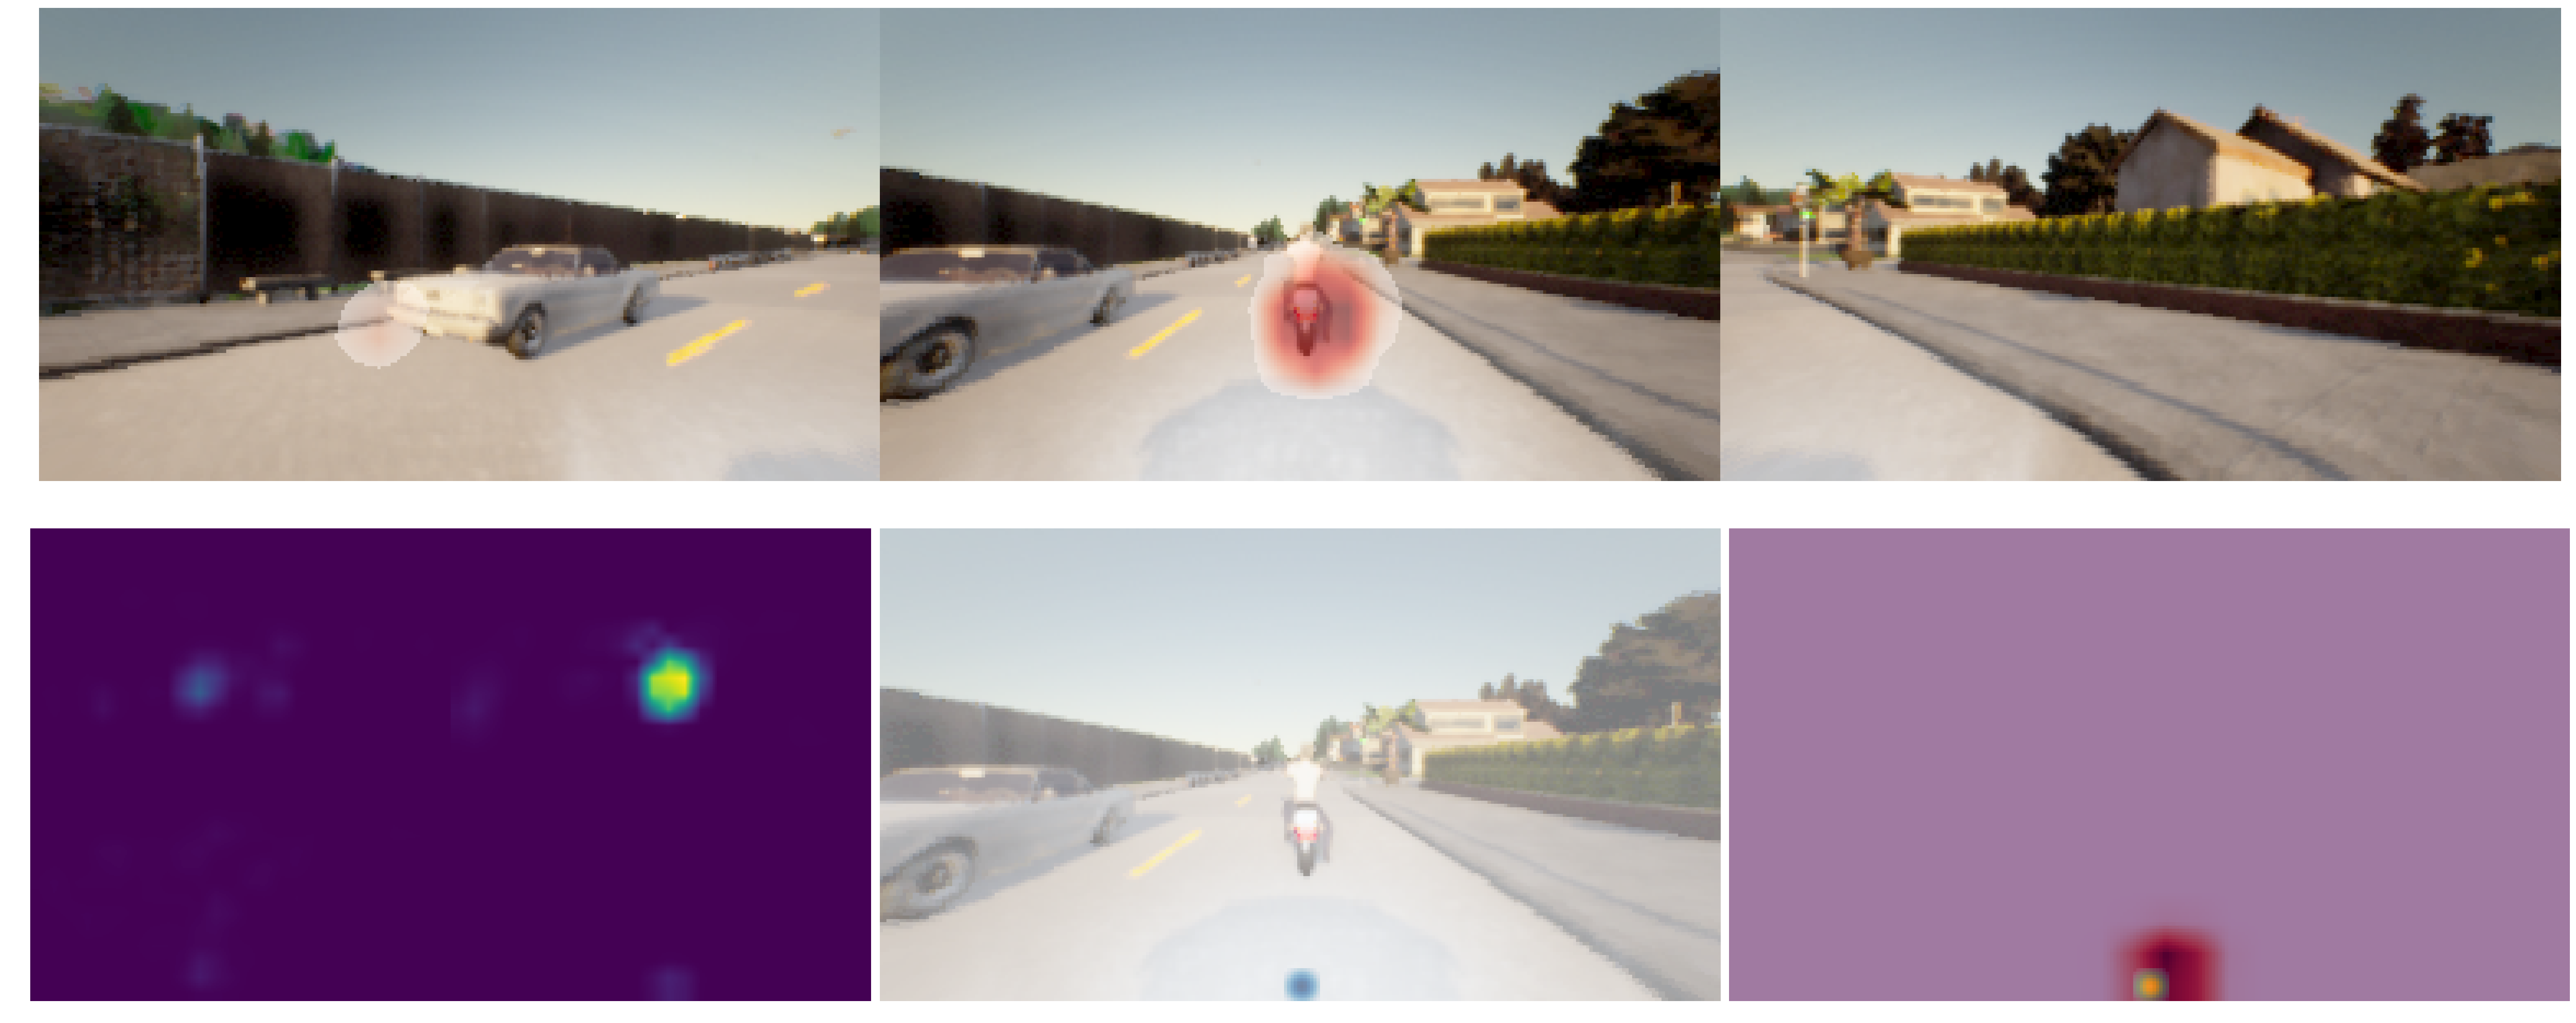

In [117]:
# A new set of data
f = plt.figure(figsize=[10*5, 10*2], dpi=resolution)
gs = GridSpec(nrows=2, ncols=3)# First axes
ax0 = f.add_subplot(gs[0, :])
ax0.imshow(img_3stack)
ax0.imshow(salmap_3stack, alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
ax0.axis('off')

ax1 = f.add_subplot(gs[1, 0])
salmap_all = np.vstack(
    [np.hstack([smap[:,:,1], smap[:,:,0]]),
     np.hstack([smap[:,:,2], smap[:,:,3]])
    ]
)
ax1.imshow(salmap_all)
ax1.axis('off')

ax2 = f.add_subplot(gs[1, 1])
ax2.imshow(input_data['rgb'])
ax2.imshow(target_heatmap_img, alpha=0.5, cmap=plt.get_cmap('Blues'), interpolation='none')
ax2.axis('off')

ax3 = f.add_subplot(gs[1, 2])
# ax2.hist(distribution)
ax3.imshow(target_heatmap_img)
ax3.imshow(smap[..., 3], alpha=0.5, cmap=plt.get_cmap('Reds'), interpolation='none')
ax3.axis('off')
plt.show()
plt.subplots_adjust(wspace=0, 
                    hspace=0.1)
f

## Load model to introspect (interactive testing)

In [13]:
!ls /scratch/abhijatb/Bosch22/LbC_DReyeVR/checkpoints/

imgmodel_17trainseqs_CC-1_LR-4_FT    mapmodel_18trainseqs_CC-1_LR-4_FT
imgmodel_17trainseqs_CC-2_LR-4_DRVR  mapmodel_18trainseqs_CC-2_LR-5
imgmodel_17trainseqs_CC-2_LR-4_FT    mapmodel_18trainseqs_CC-2_LR-5_FT
lbc_dreyevr_firstpass_img	     nogpsjitter_imgmodel_19trainseqs
lbc_dreyevr_firstpass_map	     nogpsjitter_imgmodel_19trainseqs_backup
mapmodel_17trainseqs_CC-1_LR-4_FT    nogpsjitter_imgmodel_19trainseqs_CC-2
mapmodel_17trainseqs_CC-2_LR-4_FT    nogpsjitter_mapmodel_19trainseqs
mapmodel_17trainseqs_CC-2_LR-5_DRVR  pre_trained


In [154]:
!ls /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config/exp_swapnil11_2022-07-14_01:08:58.068025

measurements  rgb  rgb_left  rgb_right	topdown


In [201]:
input_data = get_data(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config/exp_swapnil11_2022-07-14_01:08:58.068025")
                      , 22)

In [202]:
path_to_conf_file = LBC_root / "checkpoints/imgmodel_17trainseqs_CC-1_LR-4_FT/epoch=27.ckpt"
dreyevr_img_agent = ImageAgent(str(path_to_conf_file))

<All keys matched successfully>


In [203]:
d=10
r=10
aggregate_method="leading"
smap = score_frame_batched(dreyevr_img_agent, input_data, r, d, interp_func=occlude, pt_aggregate=aggregate_method, batch_size=96)

In [204]:
pt_aggregate="leading"

In [205]:
input_data = dreyevr_img_agent.offline_tick(input_data)
L = fwd_img_model(dreyevr_img_agent, input_data)

In [206]:
# def fwd_img_cmd_model(dreyevr_img_agent, input_data, mask=None):
tick_data = dreyevr_img_agent.offline_tick(input_data)
tick_data = deepcopy(input_data)
# order is 'rgb', 'rgb_left', 'rgb_right'
img = torchvision.transforms.functional.to_tensor(tick_data['image'])
img = img[None].cuda()
target = torch.from_numpy(tick_data['target'])
target = target[None].cuda()
# get the unomdified target image
target_heatmap_cam = dreyevr_img_agent.net.target_to_target_heatmap(img, target)
target_img_OG = target_heatmap_cam.detach().cpu().numpy()
input_data['target_img'] = target_img_OG.squeeze()[None]
L = fwd_img_target_model(dreyevr_img_agent, input_data)

In [ ]:
batch_size=24
interp_func = occlude

In [239]:
%%time
# batched
num_max_channels = 4 if include_target else 3

masked_data_arr = np.empty((int(post_h/d)+1, int(post_w/d)+1, num_max_channels), dtype=dict)    

for i in range(0,post_h,d):
    for j in range(0,post_w,d):
        for k in range(0, num_max_channels): # this is for the channel rgb/left/right
            masked_data_arr[int(i/d),int(j/d), k] = get_and_apply_mask([i,j], input_data, r, interp_func, k)
masked_data_flat = masked_data_arr.reshape(-1)

# aggregate batches for forward
num_batches = int(masked_data_flat.size/batch_size)
num_batches = (num_batches+1) if masked_data_flat.size%batch_size else num_batches
scores = np.zeros(shape=masked_data_flat.shape)

for i in range(num_batches):
    if i < num_batches-1:
        batch_data = masked_data_flat[i*batch_size:(i+1)*batch_size]        
    else:
        batch_data = masked_data_flat[i*batch_size:]    

    if include_target:
        flat_logits = fwd_img_target_model_batch(dreyevr_img_agent, batch_data)
    else:
        flat_logits = fwd_img_model_batch(dreyevr_img_agent, batch_data)

    if pt_aggregate=="leading":
        score_temp = (L-flat_logits)[:,:2,:].pow(2).sum(dim=[1,2]).mul_(.5).data.tolist()
    else:
        score_temp = (L-flat_logits).pow(2).sum(dim=[1,2]).mul_(.5).data.tolist()

    if i< num_batches-1:
        scores[i*batch_size:(i+1)*batch_size] = score_temp
    else:
        scores[i*batch_size:] = score_temp
scores = scores.reshape(masked_data_arr.shape)

CPU times: user 44 s, sys: 718 ms, total: 44.7 s
Wall time: 14.3 s


In [241]:
include_target = True
num_max_channels = 4 if include_target else 3
scores = np.zeros((int(post_h/d)+1,int(post_w/d)+1, num_max_channels)) # saliency scores S(t,i,j)

In [242]:
%%time
# non-batched
for i in range(0,post_h,d):
    for j in range(0,post_w,d):
        for k in range(0, num_max_channels): # this is for the channel rgb/left/right
            mask = get_mask(center=[i,j], size=[post_h,post_w], r=r)
            masked_data = apply_mask(input_data, mask, occlude, channel=k)
            # masked image logits
            l = fwd_img_target_model(dreyevr_img_agent, masked_data)
            # this corresponds to 
            if pt_aggregate=="leading":
                scores[int(i/d),int(j/d), k] = (L-l)[:,:2,:].pow(2).sum().mul_(.5).data.item()
            elif pt_aggregate=="all":
                scores[int(i/d),int(j/d), k] = (L-l).pow(2).sum().mul_(.5).data.item()
            else:
                raise ValueError("only 'leading'(first 2) and 'all' aggregations are supported")

pmax = scores.max()
scores = cv2.resize(scores, dsize=(post_w, post_h), interpolation=cv2.INTER_LINEAR).astype(np.float32)
smap = pmax * scores / scores.max()
smap = smap.astype(int)

CPU times: user 1min 35s, sys: 824 ms, total: 1min 36s
Wall time: 32.2 s


In [256]:
smap = pmax * scores / scores.max()
smap = smap.astype(int)

In [257]:
# show salience across images
salmap_3stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2]])
img_3stack = np.hstack([input_data['image'][...,3:6],
                        input_data['image'][...,0:3],
                        input_data['image'][...,6:9]])

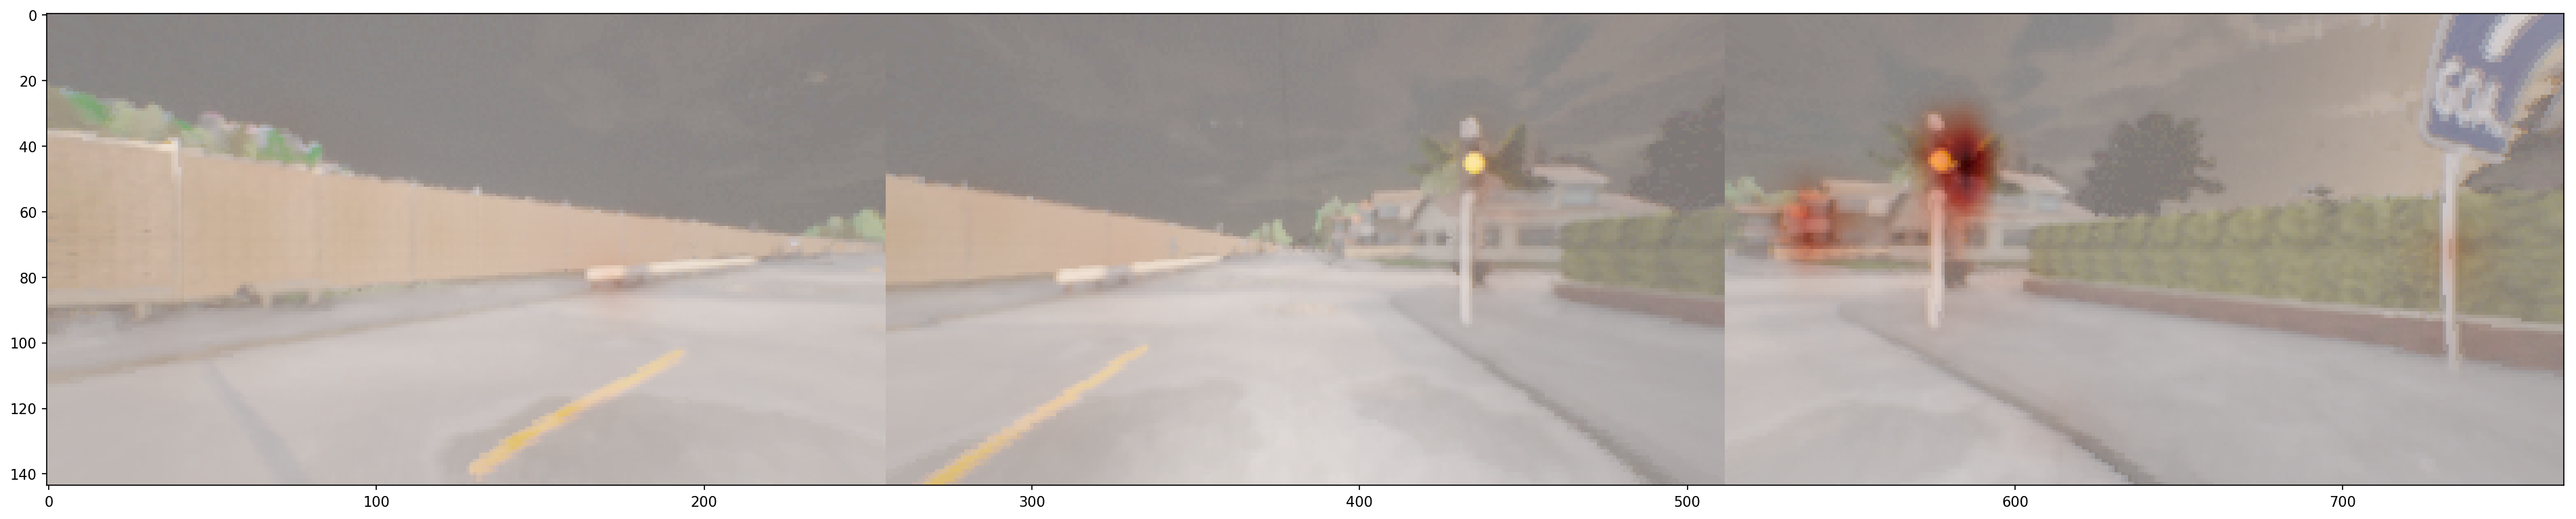

In [258]:
f = plt.figure(figsize=[10*3.2, 10], dpi=150)
plt.imshow(img_3stack, alpha=1)
plt.imshow(salmap_3stack, alpha=0.5, cmap=plt.get_cmap('Reds'))
plt.show()


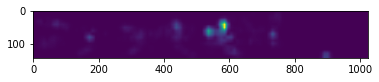

In [255]:
f = plt.figure()
salmap_4stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2], smap[:,:,3]])
plt.imshow(salmap_4stack)
plt.show()

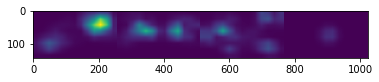

In [141]:
f = plt.figure()
salmap_4stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2], smap[:,:,3]])
plt.imshow(salmap_4stack)
plt.show()

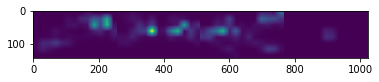

In [150]:

f = plt.figure()
salmap_4stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2], smap[:,:,3]])
plt.imshow(salmap_4stack)
plt.show()

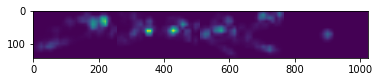

In [133]:
# this is the 10,10 one
f = plt.figure()
salmap_4stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2], smap[:,:,3]])
plt.imshow(salmap_4stack)
plt.show()

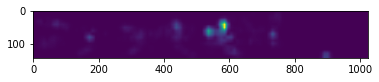

In [211]:
f = plt.figure()
salmap_4stack = np.hstack([smap[:,:,1], smap[:,:,0], smap[:,:,2], smap[:,:,3]])
plt.imshow(salmap_4stack)
plt.show()

In [67]:
# THIS IS WIP FOR GPU PARALLEL mask application
%%time
# pregen the masks
masks = np.zeros((int(post_h/d)+1, int(post_w/d)+1, post_h, post_w))
for i in range(0,post_h,d):
    for j in range(0,post_w,d):
#         for k in range(0, 4): # this is for the channel rgb/left/right
        masks[int(post_h/d), int(post_w/d), :,:] = get_mask(center=[i,j], size=[post_h,post_w], r=r)
# this is num_channels x (int(post_h/d)+1, int(post_w/d)+1, post_h, post_w)
masks_exp = np.repeat(masks[np.newaxis,...], 4, axis=0)

# I*(1-mask) + gaussian_filter(I, sigma=3)*mask

CPU times: user 1.32 s, sys: 74.8 ms, total: 1.4 s
Wall time: 1.4 s


In [23]:
input_img =  input_data['image'][...,k*3:k*3+3] if k <3 else input_data['image'][...,-1]
f = plt.figure()
plt.imshow(input_img)
plt.show()
f

NameError: name 'k' is not defined

In [ ]:
masked_img = masked_data['image'][...,k*3:k*3+3] if k <3 else masked_data['image'][...,-1]
f = plt.figure()
plt.imshow(masked_img)
plt.show()
f

In [ ]:
for i in range(0,post_h,d):
    for j in range(0,post_w,d):
        for k in range(0,3): # this is for the channel rgb/left/right/target
            break
            mask = get_mask(center=[i,j], size=[post_h,post_w], r=r) # perturbation mask
            masked_data = apply_mask(input_data, mask, interp_func, channel=k)
            l = fwd_img_model(dreyevr_img_agent, masked_data)
            scores[int(i/d),int(j/d), k] = (L-l).sum()
# avoid range artifacts while resizing
pmax = scores.max()
scores = cv2.resize(scores, dsize=(post_h,post_w), interpolation=cv2.INTER_LINEAR).astype(np.float32)
# return pmax * scores / scores.max()

In [ ]:
logits.shape

In [ ]:
points_world

In [ ]:
angle = np.degrees(np.pi / 2 - np.arctan2(aim[1], aim[0])) / 90
steer = self._turn_controller.step(angle)
steer = np.clip(steer, -1.0, 1.0)

In [ ]:
flat_logits = logits.view(logits.shape[:-2] + (-1,))
flat_logits.shape

In [ ]:
logits.shape

In [ ]:
points.shape

In [ ]:
def fwd_for_saliency(self, input_data):
    tick_data = self.offline_tick(input_data)

    img = torchvision.transforms.functional.to_tensor(tick_data['image'])
    img = img[None].cuda()

    target = torch.from_numpy(tick_data['target'])
    target = target[None].cuda()

    points, (target_cam, _) = self.net.forward(img, target)
    points_cam = points.clone().cpu()
    points_cam[..., 0] = (points_cam[..., 0] + 1) / 2 * img.shape[-1]
    points_cam[..., 1] = (points_cam[..., 1] + 1) / 2 * img.shape[-2]
    points_cam = points_cam.squeeze()
    points_world = self.converter.cam_to_world(points_cam).numpy()

    aim = (points_world[1] + points_world[0]) / 2.0
    angle = np.degrees(np.pi / 2 - np.arctan2(aim[1], aim[0])) / 90
    steer = self._turn_controller.step(angle)
    steer = np.clip(steer, -1.0, 1.0)

    desired_speed = np.linalg.norm(points_world[0] - points_world[1]) * 2.0
    # desired_speed *= (1 - abs(angle)) ** 2

    speed = tick_data['speed']

    brake = desired_speed < 0.4 or (speed / desired_speed) > 1.1

    delta = np.clip(desired_speed - speed, 0.0, 0.25)
    throttle = self._speed_controller.step(delta)
    throttle = np.clip(throttle, 0.0, 0.75)
    throttle = throttle if not brake else 0.0

    control = carla.VehicleControl()
    control.steer = steer
    control.throttle = throttle
    control.brake = float(brake)

    if DEBUG:
        debug_display(
                tick_data, target_cam.squeeze(), points.cpu().squeeze(),
                steer, throttle, brake, desired_speed,
                self.step)

    return control


In [ ]:
points_cam[..., 0]

In [ ]:
def run_step(self, input_data, timestamp):
    if not self.initialized:
        self._init()

    tick_data = self.tick(input_data)

    img = torchvision.transforms.functional.to_tensor(tick_data['image'])
    img = img[None].cuda()

    target = torch.from_numpy(tick_data['target'])
    target = target[None].cuda()

    points, (target_cam, _) = self.net.forward(img, target)
    points_cam = points.clone().cpu()
    points_cam[..., 0] = (points_cam[..., 0] + 1) / 2 * img.shape[-1]
    points_cam[..., 1] = (points_cam[..., 1] + 1) / 2 * img.shape[-2]
    points_cam = points_cam.squeeze()
    points_world = self.converter.cam_to_world(points_cam).numpy()

    aim = (points_world[1] + points_world[0]) / 2.0
    angle = np.degrees(np.pi / 2 - np.arctan2(aim[1], aim[0])) / 90
    steer = self._turn_controller.step(angle)
    steer = np.clip(steer, -1.0, 1.0)

    desired_speed = np.linalg.norm(points_world[0] - points_world[1]) * 2.0
    # desired_speed *= (1 - abs(angle)) ** 2

    speed = tick_data['speed']

    brake = desired_speed < 0.4 or (speed / desired_speed) > 1.1

    delta = np.clip(desired_speed - speed, 0.0, 0.25)
    throttle = self._speed_controller.step(delta)
    throttle = np.clip(throttle, 0.0, 0.75)
    throttle = throttle if not brake else 0.0

    control = carla.VehicleControl()
    control.steer = steer
    control.throttle = throttle
    control.brake = float(brake)
    return control

In [ ]:
target_cam

In [7]:
def get_data(route_data_path, sampled_dataidx):
    route_rgb_path = route_data_path / 'rgb'
    route_rgb_pathL = route_data_path / 'rgb_left'
    route_rgb_pathR = route_data_path / 'rgb_right'
    route_measurements_path = route_data_path / 'measurements'

    rgb_img_path = route_rgb_path / '{:04d}.png'.format(sampled_dataidx)
    rgb_imgL_path = route_rgb_pathL / '{:04d}.png'.format(sampled_dataidx)
    rgb_imgR_path = route_rgb_pathR / '{:04d}.png'.format(sampled_dataidx)
    rgb_img = Image.open(str(rgb_img_path))
    rgb_imgL = Image.open(str(rgb_imgL_path))
    rgb_imgR = Image.open(str(rgb_imgR_path))

    measure_path = route_measurements_path / '{:04d}.json'.format(sampled_dataidx)
    with open(measure_path) as read_file:
        json_str = read_file.readline()
        input_data = ast.literal_eval(json_str)
    input_data['rgb'] = rgb_img
    input_data['rgb_left'] = rgb_imgL
    input_data['rgb_right'] = rgb_imgR
    return input_data